In [1]:
### IN THIS SIMULATION, WE MAKE A PROCESS, WITH:
### INPUT: A TWO-STRAIN SIS QUASI-NEUTRAL SYSTEM
### OUTPUT: SOLUTION FOR THE CORRESPONDING REPLICATOR SYSTEM
### ESTIMATE OF THE ERROR WHEN USING OUR APPROXIMATION IN PAPER:
### "Disentangling How Multiple Traits Drive 2 Strain Frequencies in SIS Dynamics with Coinfection"

import numpy as np
import pylab as p
import scipy.integrate  as  ode
import matplotlib.pyplot  as  plt
import math
import timeit

np.set_printoptions(linewidth = 130, precision = 13)
%matplotlib inline

from scipy.optimize import fsolve
from scipy import integrate

In [2]:
def repli_para(**kwargs): #input: beta, gamma, k, trans, clear, co_clear, prob, co_interact, eps
    # COMPUTE THE VARIATIONS IN PERTURBATION OF TRAITS
    del_b     = (trans[0] - trans[1])/(beta*eps) # in transmission rates
    del_nu    = (clear[1] - clear[0])/(gamm*eps) # in infection clearance rates
    del_omega = (prob[0][1] - prob[1][0])/eps # in transmission capacity from a coinfected host
    nu2d = (co_clear/gamm - 1)/eps # in coinfection clearance rates
    alp = (co_interact - k)/eps #co-colonization interaction
    
    return del_b, del_nu, nu2d, del_omega, alp

In [3]:
def neutral_parameter(**kwargs):
    #input: beta, gamma, k, trans, clear, co_clear, prob, co_interact, eps, del_b, del_nu, u2d, del_omega, alp
    #stable state values: S*, T*, I*, J* and determinant of matrix
    S_star = m/beta
    T_star = 1 - S_star
    I_star = m*T_star/(m + beta*k*T_star)
    J_star = T_star - I_star
    detP   = 2*(T_star)**2 - I_star*J_star
    
    #coefficients for replicator equations: theta 1,2,3,4,5
    teth1 = 2*beta*S_star*(T_star)**2/detP
    teth2 = gamm*I_star*(I_star + T_star)/detP
    teth3 = gamm*T_star*J_star/detP
    teth4 = 2*m*T_star*J_star/detP
    teth5 = beta*T_star*I_star*J_star/detP
    return S_star, T_star, I_star, J_star, detP, teth1, teth2, teth3, teth4, teth5

def initial(**kwargs): # compute the initial value for the replicator system
    u0 = np.zeros(n)
    Y0 = X0[0: n*n] # initial values for co-infected hosts
    Y0 = Y0.reshape(n, n)
    for i in range (0, n):
        u0[i] = (1/detP)*(-J_star*X0[n*n + i] + 2*(T_star**2)*(X0[n*n + i] + np.dot(prob[i,:], Y0[i,:]) + np.dot(1- prob[:,i],Y0[:,i]) ))
    u0 = u0/sum(u0)
    return u0
    
def replicator(**kwargs): 
    #fitness matrix
    lambd = np.zeros((2,2))
    lambd[0][1]=  teth1*del_b + teth2*del_nu + teth3*(-nu2d[0][1]-nu2d[1][0]+2*nu2d[1][1]) + teth4*del_omega + teth5*((I_star/J_star)*(alp[1][0] - alp[0][1]) + alp[1][0] - alp[1][1])
    lambd[1][0]= -teth1*del_b - teth2*del_nu + teth3*(-nu2d[1][0]-nu2d[0][1]+2*nu2d[0][0]) - teth4*del_omega + teth5*((I_star/J_star)*(alp[0][1] - alp[1][0]) + alp[0][1] - alp[0][0])
    #input the replicator equations
    def du_dt(u, t = 0):
        return u*(np.dot(lambd,u) - np.dot(np.dot(lambd,u),u))
    
    # input the initial value for replicator equations
    t = np.linspace(0, time, itt)
    
    #solve the replicator equations
    u, infodict = integrate.odeint(du_dt, u0, t, full_output=True)
    infodict['message']
    #solution at time 100
    sol_re = u.T
    
    return sol_re

In [4]:
#matrix of Force infection =  beta_i * J_i for each strain
def lambd_rate(X):
    lambd = np.zeros(n)
    Y = X[0: n*n]
    Y = Y.reshape(n, n)
    for i in range (0, n):
            lambd[i] = trans[i]*(X[n*n + i] + np.dot(prob[i,:], Y[i,:]) + np.dot(1- prob[:,i], Y[:,i]))
    return lambd

# Solve the original quasi-neutral SIS system
def solveSIS(**kwargs):
    # The original quasi neutral SIS system
    def SIS(X, t = 0):
        deriv = np.zeros(n*n + n + 1)
        F = lambd_rate(X) #force F: beta_i*(I_i + sum (p^i_{ij}I_{ij} + p^i_{ji}I_{ji}))
        #separate X into 3 blocks: I_{ij}, I_{i} and S
        Y = X[0: n*n]
        I_ij = Y.reshape(n,n) #coinfected hosts: I_{ij}
        I_i = X[n*n: n*n + n] #infected hosts: I_i
        
        # 1st part: equations for I_ij
        Z = np.zeros((n,n))
        for i in range (0, n):
            for j in range (0, n):
                Z[i][j] = co_interact[i][j]*I_i[i]*F[j] - (r + co_clear[i][j])*I_ij[i][j]        
        Z_new = Z.reshape(n*n)
        for i in range (0, n*n):
            deriv[i] = Z_new[i]
        
        #2nd part: equations for I_i
        temp = X[-1]*F - (r + clear)*I_i - I_i*(np.dot(co_interact, F))
        for i in range (n*n, n*n + n):
            deriv[i] = temp[i - n*n]
        
        #3rd part: equation for S
        deriv[-1] = r*(1 - X[-1]) + np.sum(clear*I_i) + np.sum(co_clear* I_ij) - X[-1]*np.sum(F)
        return deriv
    
    t = np.linspace(0, time_fix/eps, itt_fix/eps)
    
    X, infodict = integrate.odeint(SIS, X0, t, full_output=True)
    infodict['message']
    sol_or = X.T
    
    return sol_or

In [5]:
r = 0.3
eps = 0.3
time_fix = 1000
itt_fix = 1000*25
n = 2

def create_sys(**kwargs): #Create quasi-neutral SIS system base on eps = 0.2
    beta = 3*np.random.rand(1) + 3.3
    gamm = np.random.rand(1) + 2
    m = gamm + r
    k = 2*(np.random.rand(1) + 0.5)
    
    trans = beta*(1 + eps*(np.random.rand(n) - 1))
    clear = gamm*(1 + eps*(np.random.rand(n) - 1))
    co_clear = gamm*(1 + eps*(np.random.rand(n,n) - 1)) 

    omega = np.zeros((2,2))
    omega[0,1] = np.random.rand(1) - 1
    omega[1,0] = np.random.rand(1) - 1
    prob = 1/2 + eps*omega

    co_interact = k + eps*(np.random.rand(n,n) - 1) #co-colonization interaction k_{ij}
    
    return beta, gamm, m, k, trans, clear, co_clear, omega, prob, co_interact

def compute_error(**kwargs):
    sol_re = replicator()
    value_re = sol_re[:,-1]
    
    Y = sol[0: 2*2]
    I_ij = Y.reshape(2,2)
    I_i = sol[2*2: 2*2 + 2]
    
    u_ij = np.zeros((2,2))
    for i in range (0, 2):
        for j in range (0, 2):
            u_ij[i][j] = value_re[i]*value_re[j]
    #error
    err_cell = np.linalg.norm(sol[-1] - S_star) + np.linalg.norm(I_i - I_star*value_re) + np.linalg.norm(I_ij - J_star*u_ij)
    return err_cell

In [6]:
#solution of original system at t=1000
error = []
ematrix = np.linspace(0.01, 0.2, 20) #number of different epsilon
    
for cursor in range (0, 25):
    system_err = [] #return 20-system error matrix to empty array
    
    #Create randomly a quasi-neutral system
    beta, gamm, m, k, trans, clear, co_clear, omega, prob, co_interact= create_sys()
    X0 = np.random.rand((n**2 + n + 1)) #initial value
    X0 = X0/np.sum(X0) # normalize intial value for SIS model
    sol_or = solveSIS() #solve the quasi-neutral system for t = 1000
    sol = sol_or[:,-1]
    
    for epsilon in ematrix:
        #Compute the corresponding replicator system
        del_b, del_nu, nu2d, del_omega, alp = repli_para()
        S_star, T_star, I_star, J_star, detP, teth1, teth2, teth3, teth4, teth5 = neutral_parameter()
        u0 = initial()
        time = time_fix*epsilon
        itt = 25*time
        
        #error
        err_cell = compute_error()
        system_err.append(err_cell)
        
    error.append(system_err)
    cursor = cursor + 1
    
error = np.array(error)
average_error = error.mean(0)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Text(0, 0.5, 'Mean Error')

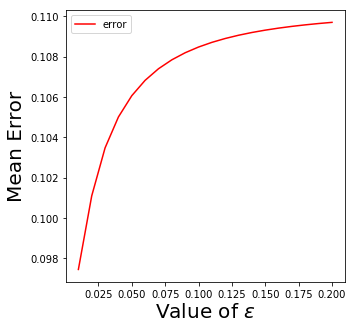

In [7]:
f1 = plt.figure(figsize=(5,5))
plt.plot(ematrix, average_error, 'r-', label='error')

plt.legend(loc='best')
plt.xlabel("Value of $\epsilon$", fontsize=20)
plt.ylabel("Mean Error", fontsize = 20)
#plt.title("Error $\epsilon = 0.1$ with $t = 1000$")